In [1]:
import os
import re
from scipy import stats
from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
from matplotlib.colors import rgb2hex
import pickle as pkl
import sys
sys.path.append('../../CEBRA_analysis')
from dataset_load import data_load
from scipy.stats import mannwhitneyu, normaltest, ttest_ind, levene, ttest_rel


In [2]:
skipdates = ["220818", "220819"]
input_folder = "/sc-projects/sc-proj-cc15-ag-wenger-retune/data_kinematic_states_neural/"
VICON_FS = 200
variables_to_drop = ["ANIMAL_ID", "CONDITION", "RUN", "DATE", "EVENT", "ECOG_LEFT_fooof_a_knee", "ECOG_RIGHT_fooof_a_knee"]

combos = [[0,2], [0,1], [1,2]]
sl = 0.05
font = 10
w = 0.8

In [3]:
data_dict = data_load(input_folder, variables_to_drop, skipdates)
df = data_dict["X_pd"]
df["event"] = data_dict["y_pd"]
df["animal"] = data_dict["animals_id_pd"]

groups_mean = df.groupby(by=["event","animal"]).mean()
groups_mean.reset_index(inplace=True)
groups_mean.drop(["animal"], inplace=True, axis=1)

No file found for 230425 NWE00161 02
No file found for 230425 NWE00161 08
No file found for 230425 NWE00160 04
No file found for 230425 NWE00160 03
No file found for 230425 NWE00164 21


In [4]:
groups_mean

,event,left_crest_angle_mean,left_hip_angle_mean,left_knee_angle_mean,left_ankle_angle_mean,right_crest_angle_mean,right_hip_angle_mean,right_knee_angle_mean,right_ankle_angle_mean,trunk_cross_l_angle_mean,...,coh_ECOG_RIGHT_to_ECOG_LEFT_mean_fband_high gamma,coh_ECOG_RIGHT_to_ECOG_LEFT_max_fband_high gamma,coh_ECOG_RIGHT_to_ECOG_LEFT_max_allfbands_high gamma,icoh_ECOG_RIGHT_to_ECOG_LEFT_mean_fband_low beta,icoh_ECOG_RIGHT_to_ECOG_LEFT_max_fband_low beta,icoh_ECOG_RIGHT_to_ECOG_LEFT_mean_fband_high beta,icoh_ECOG_RIGHT_to_ECOG_LEFT_max_fband_high beta,icoh_ECOG_RIGHT_to_ECOG_LEFT_mean_fband_high gamma,icoh_ECOG_RIGHT_to_ECOG_LEFT_max_fband_high gamma,icoh_ECOG_RIGHT_to_ECOG_LEFT_max_allfbands_high gamma
0,0,0.257894,-0.088867,-0.189259,-0.482442,0.633620,0.664620,0.473618,-0.330888,-0.473635,...,0.781234,0.603585,0.308386,-0.179553,-0.179553,-0.130756,-0.306972,-0.244915,-0.459916,-0.262468
1,0,-1.124197,1.324600,1.038463,0.890703,-0.855631,1.276941,0.858106,1.244582,0.140705,...,0.278424,0.387047,0.177681,-0.390653,-0.390653,-0.291612,-0.410544,-0.363580,-0.278939,-0.216683
2,0,0.560189,-0.227120,0.104538,0.250988,0.278557,-0.162399,-0.074268,-0.216964,0.261434,...,-0.167266,0.117629,0.269422,-0.253911,-0.253911,-0.231377,-0.401522,-0.304861,0.435882,-0.129755
3,0,-1.173785,0.800106,0.934844,0.922163,-1.407947,1.368340,1.581416,1.836304,0.713855,...,0.571499,0.497577,0.086317,-0.335015,-0.335015,-0.264829,-0.311848,-0.179030,-0.107902,0.239833
4,0,-0.363956,-0.050331,-0.334065,0.105665,-0.261342,-0.857402,-1.057248,-0.097568,0.611607,...,-1.607914,-1.572839,-0.380552,1.036247,1.036247,0.735461,0.957397,0.798162,1.065959,0.429713
5,0,-0.047497,0.171494,0.083032,0.307114,-0.527365,-0.673692,-1.038030,-0.805322,0.234791,...,0.724077,0.609486,-0.140084,-0.303716,-0.303716,-0.357402,-0.264446,-0.287427,-0.240421,-0.242058
6,1,0.562195,-0.136132,0.018298,-0.147520,0.862004,0.416309,0.350852,-0.403672,-0.630598,...,0.733667,0.598493,0.214243,-0.198186,-0.198186,-0.173638,-0.225354,-0.246754,-0.536272,-0.163872
7,1,-0.592577,1.011437,0.705176,0.910053,-0.550199,0.948505,0.881176,0.933928,0.202389,...,0.297901,0.392516,0.109360,-0.294585,-0.294585,-0.237831,-0.266577,-0.300344,-0.285461,-0.136965
8,1,0.320866,0.384012,0.223266,0.049955,-0.037929,0.283912,0.193681,0.100937,-0.066301,...,0.091085,0.252031,0.107675,-0.247942,-0.247942,-0.168405,-0.288834,-0.268630,-0.036947,-0.088741
9,1,-1.073934,0.721775,0.870457,0.708796,-1.282875,1.263038,1.479294,1.760373,0.695573,...,0.605323,0.523957,-0.065655,-0.331288,-0.331288,-0.158282,-0.187703,-0.087065,-0.324540,0.128826


In [5]:
feats = ['ECOG_LEFT_fft_high beta', 'ECOG_RIGHT_fft_high gamma', "ECOG_RIGHT_RawHjorth_Mobility", "ECOG_LEFT_RawHjorth_Complexity"]

pvals = {}
combos_ref = [[0,2], [0,1], [1,2]]
for cond in feats:
    combos = [combos_ref[0], combos_ref[2], combos_ref[1]]
    pvals[cond] = []
    for combo in combos:
        x1, x2 = combo[0], combo[1]
        data1 = groups_mean[cond][groups_mean["event"]==combo[0]]
        data2 = groups_mean[cond][groups_mean["event"]==combo[1]]
        pval = ttest_rel(data1, data2).pvalue
        #pvals[cond].append({f"{x1}{x2}": pval})
        pvals[cond].append(pval)

In [6]:
pvals_df = pd.DataFrame.from_dict(pvals, orient='index',
                       columns=["02","12", "01", ])
pvals_df = pvals_df.melt(ignore_index=False)

In [7]:
def bonferroni_holm(pvals, alpha):
    sortind = np.argsort(pvals)
    pvals = np.take(pvals, sortind)
    ntests = len(pvals)
    alphacSidak = 1 - np.power((1. - alpha), 1./ntests)
    alphacBonf = alpha / float(ntests)
    notreject = pvals > alpha / np.arange(ntests, 0, -1)
    nr_index = np.nonzero(notreject)[0]
    if nr_index.size == 0:
        # nonreject is empty, all rejected
        notrejectmin = len(pvals)
    else:
        notrejectmin = np.min(nr_index)
    notreject[notrejectmin:] = True
    reject = ~notreject
    pvals_corrected_raw = pvals * np.arange(ntests, 0, -1)
    pvals_corrected = np.maximum.accumulate(pvals_corrected_raw)
    pvals_corrected_ = np.empty_like(pvals_corrected)
    pvals_corrected_[sortind] = pvals_corrected
    reject_ = np.empty_like(reject)
    reject_[sortind] = reject
    return reject_, pvals_corrected_, alphacSidak, alphacBonf

In [8]:
reject_, pvals_corrected_, alphacSidak, alphacBonf =  bonferroni_holm(np.asarray(pvals_df["value"]), alpha=0.05)

In [9]:
pvals_df["reject"] = reject_
pvals_df["pvals_corrected"] = pvals_corrected_

In [10]:
pvals_df

,variable,value,reject,pvals_corrected
ECOG_LEFT_fft_high beta,02,0.008751,False,0.078755
ECOG_RIGHT_fft_high gamma,02,0.000971,True,0.010681
ECOG_RIGHT_RawHjorth_Mobility,02,0.115884,False,0.425190
ECOG_LEFT_RawHjorth_Complexity,02,0.000547,True,0.006566
ECOG_LEFT_fft_high beta,12,0.011606,False,0.089992
ECOG_RIGHT_fft_high gamma,12,0.110228,False,0.425190
ECOG_RIGHT_RawHjorth_Mobility,12,0.295975,False,0.425190
ECOG_LEFT_RawHjorth_Complexity,12,0.015634,False,0.093807
ECOG_LEFT_fft_high beta,01,0.011249,False,0.089992
ECOG_RIGHT_fft_high gamma,01,0.016672,False,0.093807


/tmp/ipykernel_3246241/2893815925.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=groups_mean, y=cond, x="event", ax=axs, palette=["cyan", "#2e2d4d", "m"], legend=False, width=w)
/tmp/ipykernel_3246241/2893815925.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=groups_mean, y=cond, x="event", ax=axs, palette=["cyan", "#2e2d4d", "m"], legend=False, width=w)
/tmp/ipykernel_3246241/2893815925.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=groups_mean, y=cond, x="event", ax=axs, palette=["cyan", "#2e2d4d", "m"], legend

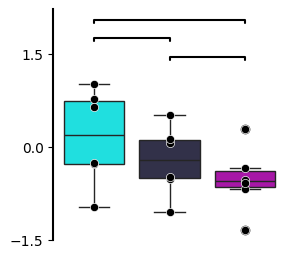

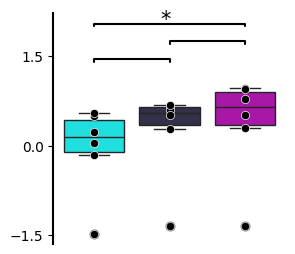

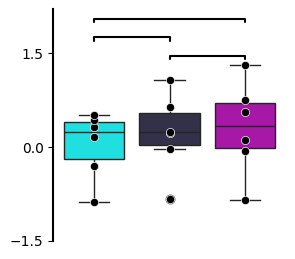

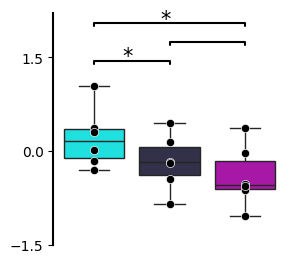

In [11]:


for cond in feats:
    fig, axs = plt.subplots(figsize=(3,3))
    combos = [combos[0], combos[2], combos[1]]

    sns.boxplot(data=groups_mean, y=cond, x="event", ax=axs, palette=["cyan", "#2e2d4d", "m"], legend=False, width=w)
    chart = sns.scatterplot(data=groups_mean, y=cond, x="event", ax=axs, color="k", legend=False, zorder=10, s=35)
    y = 2
    for combo in combos:
        x1, x2 = combo[0], combo[1]
        sign = pvals_df[pvals_df["variable"]==f"{x1}{x2}"].loc[cond]["reject"]
        significance = "* " if sign else ""
        h, col = 0.05, 'k'
        chart.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col, solid_capstyle="round")
        chart.text((x1+x2)*.5, y-0.05,  f"{significance}", 
                       ha='center', va='bottom', color=col, fontsize=font+5)
        y-=0.3
    fn = cond.replace("_", " ")
    spaces = [m.start() for m in re.finditer(' ', fn)]
    if len(spaces)>2:
        split_space = spaces[int(len(spaces)/2)]
        fn = f"{fn[:split_space]} \n {fn[split_space+1:]}"
    #axs.set_title(fn, y=1.2, fontsize=9)
    axs.set_ylabel("")
    axs.set_xlabel("")
    axs.set_yticks([-1.5, 0, 1.5])
    axs.set_xticks([])
    axs.spines['right'].set_visible(False)
    axs.spines['top'].set_visible(False)
    axs.spines['bottom'].set_visible(False)
    axs.spines['left'].set_linewidth(1.5)
    plt.savefig(f"group_{cond}.svg", transparent=True)

In [89]:
sign

False